In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# seeds
torch.manual_seed(1337)
random.seed(1337)
np.random.seed(1337)

In [2]:
class Q_Net(nn.Module):
    def __init__(self, num_states, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(num_states, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
env = gym.make("LunarLander-v2")

state, _ = env.reset(seed=69)
num_states = len(state)
num_actions = env.action_space.n

policy_Q = Q_Net(num_states, num_actions).to(device)
target_Q = Q_Net(num_states, num_actions).to(device)
target_Q.load_state_dict(policy_Q.state_dict()) # same weights

criterion = nn.MSELoss()

from collections import deque
replay_memory = deque([], 10_000)

optimizer = optim.Adam(policy_Q.parameters(), lr=1e-3)

In [4]:
from itertools import count
from time import time

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10_000
GAMMA = 0.99
BATCH_SIZE = 64
TAU = 1e-3
PRINT_INTERVAL = 10
PRINT_INTERVAL_BIG = 100
STOP_REWARD = 250

def update_target(policy_Q, target_Q, tau):
    for target_param, policy_param in zip(target_Q.parameters(), policy_Q.parameters()):
        target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)
        
def get_next_action(env, state, policy_Q, eps):
    # select action
    if random.random() < eps:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = policy_Q(state).argmax().item()
    return action

rewards_list, eps_list = [], []
t0 = time()
steps = 0
for episode in range(2_000):
    state, _ = env.reset(seed=69)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    total_episode_reward = 0.
    for t in count():
        # perform the action
        eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps / EPS_DECAY)
        action = get_next_action(env, state, policy_Q, eps)
        
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        new_state = torch.tensor(new_state, dtype=torch.float32, device=device).unsqueeze(0)
            
        # add to replay_memory
        replay_memory.append((state, action, reward, new_state, done))
            
        # add new reward
        total_episode_reward += reward
        
        state = new_state
        
        if len(replay_memory) < BATCH_SIZE: continue
            
        # sample batch
        batch = random.sample(replay_memory, BATCH_SIZE)
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = zip(*batch)
        
        state_batch = torch.cat(state_batch)
        new_state_batch = torch.cat(new_state_batch)
        pred_Q = policy_Q(state_batch).gather(1, torch.tensor(action_batch, device=device).view(-1,1)).squeeze(1)
        
        with torch.no_grad():
            next_Q = target_Q(new_state_batch).max(1)[0]
        
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32, device=device)
        done_batch = torch.tensor(done_batch, dtype=torch.float32, device=device)
        y = (1.-done_batch)*next_Q*GAMMA + reward_batch
        
        loss = criterion(y, pred_Q)
        
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_value_(policy_Q.parameters(), 100)
        optimizer.step()
        
        update_target(policy_Q, target_Q, TAU)
        steps += 1
        
        if done: break
    rewards_list.append(total_episode_reward)
    eps_list.append(eps)
    
    if episode % PRINT_INTERVAL == 0 and len(rewards_list) >= PRINT_INTERVAL:
        print(f'\r{episode:>4}: Steps: {steps:>8} | Avg reward: {np.mean(rewards_list[-PRINT_INTERVAL:]): 8.02f} | eps: {eps:.04f} | time: {time()-t0:8.02f}', end='')
        if episode % PRINT_INTERVAL_BIG == 0:
            print(f'\r{episode:>4}: Steps: {steps:>8} | Avg reward: {np.mean(rewards_list[-PRINT_INTERVAL:]): 8.02f} | eps: {eps:.04f} | time: {time()-t0:8.02f}')
            t0 = time()
            
    if total_episode_reward > STOP_REWARD: 
        print(f'\r{episode:>4}: Steps: {steps:>8} | Avg reward: {np.mean(rewards_list[-PRINT_INTERVAL:]): 8.02f} | eps: {eps:.04f} | time: {time()-t0:8.02f}')
        print(f'EARLY STOP! Total episode reward: {total_episode_reward:.02f}')
        break
env.close()

 100: Steps:    24852 | Avg reward:   -89.92 | eps: 0.1208 | time:    62.58
 179: Steps:    71624 | Avg reward:   128.13 | eps: 0.0507 | time:   121.14
EARLY STOP! Total episode reward: 252.11


In [5]:
import os

def save_plot(fig, name, folder=None):
    '''Saves a figure'''
    path = "figures"
    if folder is not None:
        path = os.path.join(path, folder)

    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, f"{name}.png"), bbox_inches='tight')

def save_model(model, path, name):
    '''Saves torch model'''
    os.makedirs(path, exist_ok = True) 
    torch.save(model, os.path.join(path, name))

save_model(policy_Q, 'models', 'dql_model.pth')

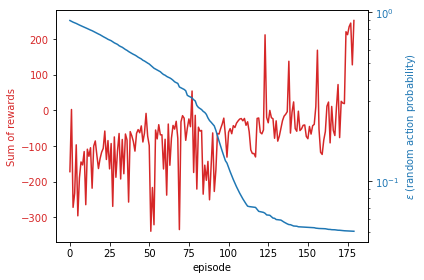

In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('episode')
ax1.set_ylabel('Sum of rewards', color=color)
ax1.plot(rewards_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel(r'$\epsilon$ (random action probability)', color=color)
ax2.plot(eps_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.tight_layout()
plt.show()

# save plot
save_plot(fig, 'dqn_reward_epsilon')

In [7]:
from gymnasium.wrappers.monitoring import video_recorder
import os

path = 'videos'
os.makedirs(path, exist_ok = True) 

# record video of the result
env = gym.make("LunarLander-v2", render_mode="rgb_array")
video = video_recorder.VideoRecorder(env, path=f'{path}/video_dqn.mp4')
state, _ = env.reset(seed=69)
while True:
    video.capture_frame()

    # next action
    with torch.no_grad():
        action = policy_Q(torch.tensor(state, device=device)).argmax().item()

    state, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated: break
video.close()
env.close()

Moviepy - Building video videos/video_dqn.mp4.
Moviepy - Writing video videos/video_dqn.mp4



Moviepy - Done !
Moviepy - video ready videos/video_dqn.mp4
